# Matrix Factorization for Recommendation

This notebook implements a Matrix Factorization model using PyTorch for learning user and item embeddings from implicit feedback.

**Model Architecture:**
- User embedding matrix: (n_users, embedding_dim)
- Item embedding matrix: (n_items, embedding_dim)
- Prediction: dot product of user and item embeddings

**Training:**
- BPR (Bayesian Personalized Ranking) loss for implicit feedback
- Negative sampling strategy

## 1. Setup and Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import pickle
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Silicon GPU (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using NVIDIA GPU (CUDA)')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Set random seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using Apple Silicon GPU (MPS)


In [2]:
# Configuration
CONFIG = {
    # Paths
    'data_dir': '../data/processed',
    'model_dir': '../models',
    'results_dir': '../results',
    
    # Model hyperparameters
    'embedding_dim': 64,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,  # L2 regularization
    
    # Training
    'batch_size': 1024,
    'n_epochs': 50,
    'n_negatives': 4,  # Negative samples per positive
    
    # Evaluation
    'top_k': [5, 10, 20],
    'eval_every': 5,  # Evaluate every N epochs
}

# Create directories
Path(CONFIG['model_dir']).mkdir(parents=True, exist_ok=True)
Path(CONFIG['results_dir']).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    if not k.endswith('_dir'):
        print(f"  {k}: {v}")

Configuration:
  embedding_dim: 64
  learning_rate: 0.001
  weight_decay: 1e-05
  batch_size: 1024
  n_epochs: 50
  n_negatives: 4
  top_k: [5, 10, 20]
  eval_every: 5


## 2. Load Data

In [3]:
# Load interaction matrices
train_matrix = sp.load_npz(os.path.join(CONFIG['data_dir'], 'train_matrix.npz'))
val_matrix = sp.load_npz(os.path.join(CONFIG['data_dir'], 'val_matrix.npz'))
test_matrix = sp.load_npz(os.path.join(CONFIG['data_dir'], 'test_matrix.npz'))

n_users, n_items = train_matrix.shape

print(f"Data loaded:")
print(f"  Users: {n_users:,}")
print(f"  Items: {n_items:,}")
print(f"  Train interactions: {train_matrix.nnz:,}")
print(f"  Validation interactions: {val_matrix.nnz:,}")
print(f"  Test interactions: {test_matrix.nnz:,}")

Data loaded:
  Users: 357
  Items: 479
  Train interactions: 2,315
  Validation interactions: 357
  Test interactions: 357


In [4]:
# Create training pairs (user, positive_item)
train_coo = train_matrix.tocoo()
train_users = train_coo.row
train_items = train_coo.col

# Get all items each user has interacted with (for negative sampling)
user_positive_items = {}
for u, i in zip(train_users, train_items):
    if u not in user_positive_items:
        user_positive_items[u] = set()
    user_positive_items[u].add(i)

print(f"Training pairs: {len(train_users):,}")

Training pairs: 2,315


## 3. Dataset and DataLoader

In [5]:
class BPRDataset(Dataset):
    """
    Dataset for BPR training with on-the-fly negative sampling.
    """
    def __init__(self, users, items, n_items, user_positive_items, n_negatives=1):
        self.users = users
        self.items = items
        self.n_items = n_items
        self.user_positive_items = user_positive_items
        self.n_negatives = n_negatives
        
    def __len__(self):
        return len(self.users) * self.n_negatives
    
    def __getitem__(self, idx):
        # Get the positive pair
        pair_idx = idx // self.n_negatives
        user = self.users[pair_idx]
        pos_item = self.items[pair_idx]
        
        # Sample a negative item
        neg_item = np.random.randint(0, self.n_items)
        while neg_item in self.user_positive_items.get(user, set()):
            neg_item = np.random.randint(0, self.n_items)
        
        return {
            'user': torch.tensor(user, dtype=torch.long),
            'pos_item': torch.tensor(pos_item, dtype=torch.long),
            'neg_item': torch.tensor(neg_item, dtype=torch.long)
        }

# Create dataset and dataloader
train_dataset = BPRDataset(
    train_users, train_items, n_items, 
    user_positive_items, CONFIG['n_negatives']
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0  # MPS works best with 0
)

print(f"Dataset size: {len(train_dataset):,} samples")
print(f"Batches per epoch: {len(train_loader):,}")

Dataset size: 9,260 samples
Batches per epoch: 10


## 4. Matrix Factorization Model

In [6]:
class MatrixFactorization(nn.Module):
    """
    Matrix Factorization model for collaborative filtering.
    
    The model learns latent embeddings for users and items.
    Prediction is the dot product of user and item embeddings.
    """
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
    def forward(self, user_ids, item_ids):
        """
        Compute prediction scores for user-item pairs.
        
        Args:
            user_ids: Tensor of user indices
            item_ids: Tensor of item indices
            
        Returns:
            Tensor of prediction scores (dot product of embeddings)
        """
        user_emb = self.user_embedding(user_ids)  # (batch, dim)
        item_emb = self.item_embedding(item_ids)  # (batch, dim)
        
        # Dot product
        scores = (user_emb * item_emb).sum(dim=1)
        return scores
    
    def get_all_item_scores(self, user_ids):
        """
        Get scores for all items for given users (for evaluation).
        
        Args:
            user_ids: Tensor of user indices (batch_size,)
            
        Returns:
            Tensor of scores (batch_size, n_items)
        """
        user_emb = self.user_embedding(user_ids)  # (batch, dim)
        all_item_emb = self.item_embedding.weight  # (n_items, dim)
        
        # Matrix multiplication for all scores
        scores = torch.matmul(user_emb, all_item_emb.T)  # (batch, n_items)
        return scores

# Initialize model
model = MatrixFactorization(n_users, n_items, CONFIG['embedding_dim'])
model = model.to(device)

print(f"Model created:")
print(f"  User embeddings: {n_users:,} x {CONFIG['embedding_dim']}")
print(f"  Item embeddings: {n_items:,} x {CONFIG['embedding_dim']}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model created:
  User embeddings: 357 x 64
  Item embeddings: 479 x 64
  Total parameters: 53,504


## 5. BPR Loss Function

In [7]:
class BPRLoss(nn.Module):
    """
    Bayesian Personalized Ranking Loss.
    
    The idea: positive items should be ranked higher than negative items.
    Loss = -log(sigmoid(pos_score - neg_score))
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, pos_scores, neg_scores):
        """
        Args:
            pos_scores: Scores for positive (interacted) items
            neg_scores: Scores for negative (sampled) items
            
        Returns:
            BPR loss value
        """
        diff = pos_scores - neg_scores
        loss = -torch.log(torch.sigmoid(diff) + 1e-8).mean()
        return loss

criterion = BPRLoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

print("Optimizer: Adam")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")

Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 1e-05


## 6. Evaluation Metrics

In [8]:
def compute_metrics(model, test_matrix, train_matrix, k_values=[5, 10, 20], batch_size=256):
    """
    Compute ranking metrics: Precision, Recall, NDCG, and Hit Rate at K.
    
    Args:
        model: The trained model
        test_matrix: Sparse matrix of test interactions
        train_matrix: Sparse matrix of training interactions (to exclude)
        k_values: List of K values for top-K metrics
        
    Returns:
        Dictionary of metrics
    """
    model.eval()
    
    # Get test users (users with at least one test interaction)
    test_coo = test_matrix.tocoo()
    test_users = np.unique(test_coo.row)
    
    # Build ground truth dict
    test_user_items = {}
    for u, i in zip(test_coo.row, test_coo.col):
        if u not in test_user_items:
            test_user_items[u] = []
        test_user_items[u].append(i)
    
    # Get training items to exclude from recommendations
    train_csr = train_matrix.tocsr()
    
    # Initialize metrics
    metrics = {f'Precision@{k}': [] for k in k_values}
    metrics.update({f'Recall@{k}': [] for k in k_values})
    metrics.update({f'NDCG@{k}': [] for k in k_values})
    metrics.update({f'HR@{k}': [] for k in k_values})
    
    with torch.no_grad():
        for i in range(0, len(test_users), batch_size):
            batch_users = test_users[i:i+batch_size]
            user_tensor = torch.tensor(batch_users, dtype=torch.long, device=device)
            
            # Get scores for all items
            scores = model.get_all_item_scores(user_tensor).cpu().numpy()
            
            # Mask out training items
            for idx, user in enumerate(batch_users):
                train_items = train_csr[user].indices
                scores[idx, train_items] = -np.inf
            
            # Get top-K items
            max_k = max(k_values)
            top_items = np.argsort(-scores, axis=1)[:, :max_k]
            
            # Compute metrics for each user
            for idx, user in enumerate(batch_users):
                if user not in test_user_items:
                    continue
                    
                ground_truth = set(test_user_items[user])
                
                for k in k_values:
                    top_k = top_items[idx, :k]
                    hits = len(set(top_k) & ground_truth)
                    
                    # Precision@K
                    metrics[f'Precision@{k}'].append(hits / k)
                    
                    # Recall@K
                    metrics[f'Recall@{k}'].append(hits / len(ground_truth))
                    
                    # Hit Rate@K
                    metrics[f'HR@{k}'].append(1.0 if hits > 0 else 0.0)
                    
                    # NDCG@K
                    dcg = sum([1.0 / np.log2(j + 2) for j, item in enumerate(top_k) if item in ground_truth])
                    idcg = sum([1.0 / np.log2(j + 2) for j in range(min(k, len(ground_truth)))])
                    metrics[f'NDCG@{k}'].append(dcg / idcg if idcg > 0 else 0.0)
    
    # Average metrics
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    return avg_metrics

## 7. Training

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc='Training', leave=False):
        users = batch['user'].to(device)
        pos_items = batch['pos_item'].to(device)
        neg_items = batch['neg_item'].to(device)
        
        # Forward pass
        pos_scores = model(users, pos_items)
        neg_scores = model(users, neg_items)
        
        # Compute loss
        loss = criterion(pos_scores, neg_scores)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [10]:
# Training loop
print("Starting training...")
print("="*60)

history = {'loss': [], 'val_ndcg': []}
best_ndcg = 0
best_epoch = 0

for epoch in range(1, CONFIG['n_epochs'] + 1):
    # Train
    loss = train_epoch(model, train_loader, criterion, optimizer, device)
    history['loss'].append(loss)
    
    # Evaluate periodically
    if epoch % CONFIG['eval_every'] == 0 or epoch == 1:
        metrics = compute_metrics(model, val_matrix, train_matrix, CONFIG['top_k'])
        ndcg = metrics['NDCG@10']
        history['val_ndcg'].append(ndcg)
        
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | NDCG@10: {ndcg:.4f} | HR@10: {metrics['HR@10']:.4f}")
        
        # Save best model
        if ndcg > best_ndcg:
            best_ndcg = ndcg
            best_epoch = epoch
            torch.save(model.state_dict(), os.path.join(CONFIG['model_dir'], 'mf_best.pt'))
    else:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f}")

print("="*60)
print(f"Training complete! Best NDCG@10: {best_ndcg:.4f} at epoch {best_epoch}")

Starting training...


Epoch   1 | Loss: 0.6928 | NDCG@10: 0.0096 | HR@10: 0.0224


Epoch   2 | Loss: 0.6917


Epoch   3 | Loss: 0.6901


Epoch   4 | Loss: 0.6876


Epoch   5 | Loss: 0.6839 | NDCG@10: 0.0222 | HR@10: 0.0392


Epoch   6 | Loss: 0.6789


Epoch   7 | Loss: 0.6727


Epoch   8 | Loss: 0.6638


Epoch   9 | Loss: 0.6548


Epoch  10 | Loss: 0.6431 | NDCG@10: 0.0172 | HR@10: 0.0448


Epoch  11 | Loss: 0.6293


Epoch  12 | Loss: 0.6142


Epoch  13 | Loss: 0.5994


Epoch  14 | Loss: 0.5818


Epoch  15 | Loss: 0.5634 | NDCG@10: 0.0146 | HR@10: 0.0392


Epoch  16 | Loss: 0.5437


Epoch  17 | Loss: 0.5242


Epoch  18 | Loss: 0.5029


Epoch  19 | Loss: 0.4847


Epoch  20 | Loss: 0.4630 | NDCG@10: 0.0127 | HR@10: 0.0336


Epoch  21 | Loss: 0.4469


Epoch  22 | Loss: 0.4249


Epoch  23 | Loss: 0.4062


Epoch  24 | Loss: 0.3879


Epoch  25 | Loss: 0.3743 | NDCG@10: 0.0121 | HR@10: 0.0336


Epoch  26 | Loss: 0.3564


Epoch  27 | Loss: 0.3393


Epoch  28 | Loss: 0.3229


Epoch  29 | Loss: 0.3086


Epoch  30 | Loss: 0.2919 | NDCG@10: 0.0123 | HR@10: 0.0308


Epoch  31 | Loss: 0.2812


Epoch  32 | Loss: 0.2651


Epoch  33 | Loss: 0.2552


Epoch  34 | Loss: 0.2505


Epoch  35 | Loss: 0.2356 | NDCG@10: 0.0146 | HR@10: 0.0364


Epoch  36 | Loss: 0.2266


Epoch  37 | Loss: 0.2159


Epoch  38 | Loss: 0.2047


Epoch  39 | Loss: 0.1949


Epoch  40 | Loss: 0.1933 | NDCG@10: 0.0140 | HR@10: 0.0336


Epoch  41 | Loss: 0.1831


Epoch  42 | Loss: 0.1738


Epoch  43 | Loss: 0.1677


Epoch  44 | Loss: 0.1610


Epoch  45 | Loss: 0.1545 | NDCG@10: 0.0135 | HR@10: 0.0280


Epoch  46 | Loss: 0.1480


Epoch  47 | Loss: 0.1444


Epoch  48 | Loss: 0.1371


Epoch  49 | Loss: 0.1353


Epoch  50 | Loss: 0.1299 | NDCG@10: 0.0157 | HR@10: 0.0336
Training complete! Best NDCG@10: 0.0222 at epoch 5


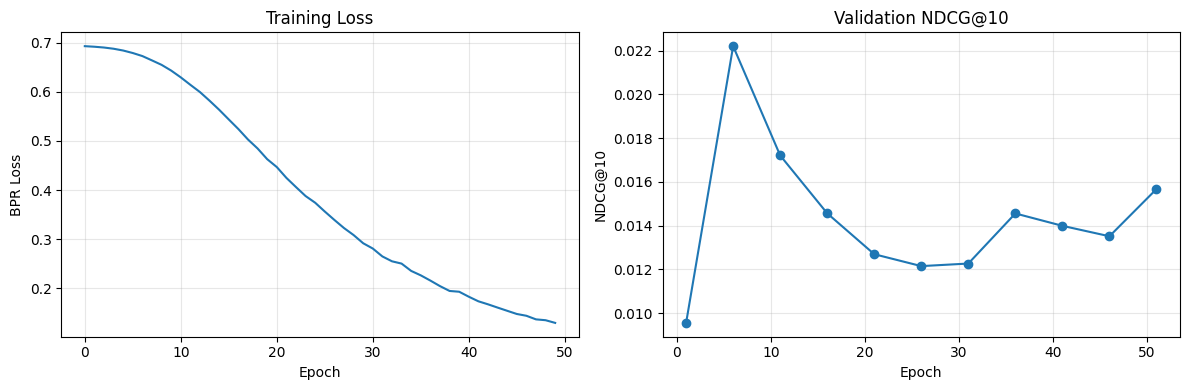

In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BPR Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# NDCG
eval_epochs = list(range(1, len(history['val_ndcg'])*CONFIG['eval_every']+1, CONFIG['eval_every']))
if len(eval_epochs) > len(history['val_ndcg']):
    eval_epochs = eval_epochs[:len(history['val_ndcg'])]
axes[1].plot(eval_epochs, history['val_ndcg'], marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('Validation NDCG@10')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'mf_training.png'), dpi=150)
plt.show()

## 8. Final Evaluation on Test Set

In [12]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'mf_best.pt')))

# Combine train and validation for final test
train_val_matrix = train_matrix + val_matrix
train_val_matrix.data = np.clip(train_val_matrix.data, 0, 1)

# Evaluate on test set
test_metrics = compute_metrics(model, test_matrix, train_val_matrix, CONFIG['top_k'])

print("="*60)
print("FINAL TEST RESULTS - Matrix Factorization")
print("="*60)
for metric, value in sorted(test_metrics.items()):
    print(f"  {metric}: {value:.4f}")

FINAL TEST RESULTS - Matrix Factorization
  HR@10: 0.0084
  HR@20: 0.0224
  HR@5: 0.0028
  NDCG@10: 0.0030
  NDCG@20: 0.0067
  NDCG@5: 0.0014
  Precision@10: 0.0008
  Precision@20: 0.0011
  Precision@5: 0.0006
  Recall@10: 0.0084
  Recall@20: 0.0224
  Recall@5: 0.0028


In [13]:
# Save results
results = {
    'model': 'MatrixFactorization',
    'config': CONFIG,
    'best_epoch': best_epoch,
    'best_val_ndcg': best_ndcg,
    'test_metrics': test_metrics,
    'history': history
}

with open(os.path.join(CONFIG['results_dir'], 'mf_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

# Also save as readable format
with open(os.path.join(CONFIG['results_dir'], 'mf_results.txt'), 'w') as f:
    f.write("Matrix Factorization Results\n")
    f.write("="*40 + "\n\n")
    f.write("Configuration:\n")
    for k, v in CONFIG.items():
        f.write(f"  {k}: {v}\n")
    f.write(f"\nBest Epoch: {best_epoch}\n")
    f.write(f"Best Validation NDCG@10: {best_ndcg:.4f}\n")
    f.write("\nTest Metrics:\n")
    for metric, value in sorted(test_metrics.items()):
        f.write(f"  {metric}: {value:.4f}\n")

print("Results saved to:")
print(f"  {CONFIG['results_dir']}/mf_results.pkl")
print(f"  {CONFIG['results_dir']}/mf_results.txt")
print(f"  {CONFIG['model_dir']}/mf_best.pt")

Results saved to:
  ../results/mf_results.pkl
  ../results/mf_results.txt
  ../models/mf_best.pt


## Summary

Matrix Factorization model trained successfully!

**Key Points:**
- Uses BPR loss for implicit feedback learning
- Negative sampling to contrast positive vs negative items
- L2 regularization to prevent overfitting

**Next Steps:**
- Compare with LSTM-based sequential model
- Compare with BERT4Rec (Transformer)
- Compare with LightGCN (Graph Neural Network)